**결측치 채우는 방법**

metric : cosine, braycurtis, canberra

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import os


from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [5]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
pvtb_dir = RSLT_DIR + 'pvtb/'

## FUNCTIONS

- preprocess

In [7]:
def count_key_opt(data:pd.DataFrame,key,opt):
    rslt = dict()
    labels = data[key].unique()
    form = data[opt].value_counts().sort_values(ascending=False)
    form.iloc[:] = 0

    for feat in labels:
        cond = data[key]==feat
        val = form.copy()
        temp = data.loc[cond,opt].value_counts()
        val.loc[temp.index] = temp
        rslt[feat] = val

    return pd.DataFrame(rslt).T

In [8]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

- plot

In [9]:
import re

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e) 
    return rslt

def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]
#알고리즘 때문에 맨 앞에 빈칸 하나 들어가게 되는 이슈 있음

print(str_cutter('Racial Segregation Indices | Racial Segregation, White and Hispanic', 13))



Racial
Segregation
Indices |
Racial
Segregation,
White and
Hispanic


In [10]:
def choose_plot_grid(n:int,r_max=8,c_max=17,res_ths=2):
    #ver2
    r_min = np.ceil(n/c_max)
    sppt = np.arange(r_min,r_max+1) #need error process
    col_nums = np.ceil(n/sppt)
    res = col_nums * sppt -n
    min_idx = np.where((res==np.min(res)) | (res <= res_ths))[0]
    row_cand, col_cand = sppt[min_idx], col_nums[min_idx]
    if len(min_idx) > 1 :
        res = np.abs(row_cand-col_cand)
        i = np.where(res==np.min(res))[0][0]
    else : i = 0
    return int(row_cand[i]), int(col_cand[i])


def pair_plot_feat_hue(fig,axes,data:dict,pair_plot,axis_share=False,hue_label_dict=None, **kwargs):
    #ver2
    if (fig is None) or (axes is None) :
        num_r, num_c = choose_plot_grid(len(data))
        fig, axes = plt.subplots(num_r,num_c,figsize=(21,17),sharex=axis_share,sharey=axis_share)
    for n,key in enumerate(data.keys()):
        ax = axes.flatten()[n]
        plt.setp(ax.get_xticklabels(),ha = 'left',rotation = 90)
        if n >= len(data) : continue
        pair_plot(x=data[key][0], y = data[key][1],ax =ax, **kwargs)
        feat_name = str(key) 
        if hue_label_dict: color = 'b' if hue_label_dict[feat_name] else 'k'
        else : color = 'k'
        ax.set_xlabel(str_cutter(feat_name,20),loc='left',fontsize = 8.3,color=color)
    return fig,axes

## pvtb_city_encoded_ver1 로 변경 , DT모델적용


In [11]:
# CSV 파일 경로
file_name = 'pvtb_city_encoded_ver1.csv'
file_path = os.path.join(RSLT_DIR,pvtb_dir,file_name)

# CSV 파일 읽기
pvtb_entire_1 = pd.read_csv(file_path, index_col=0)

# 데이터프레임의 컬럼 출력
print(pvtb_entire_1.columns.tolist())
pvtb_entire_1.head()

pvtb_entire = pvtb_entire_1[list(pvtb_entire_1.columns)[1:]]

['geo_label_city', 'encoded_strata_race_label', 'encoded_strata_sex_label', 'encoded_geo_strata_region', 'encoded_geo_strata_poverty', 'encoded_geo_strata_Population', 'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation', 'date_label', 'Active Transportation | Riding Bike to Work', 'Active Transportation | Walking to Work', 'Air Pollution | Hazardous Air Quality', 'Air Pollution | Poor Air Quality', 'Birth Control | Teen Birth Control', 'Births | Low Birthweight', 'Births | Prenatal Care', 'Births | Preterm Births', 'Births | Teen Births', 'Cancer | All Cancer Deaths', 'Cancer | Breast Cancer Deaths', 'Cancer | Colorectal Cancer Deaths', 'Cancer | Lung Cancer Deaths', 'Cancer | Prostate Cancer Deaths', 'Cardiovascular Disease | Cardiovascular Disease Deaths', 'Cardiovascular Disease | Heart Disease Deaths', 'Cardiovascular Disease | High Blood Pressure', 'Crime Incidents | Homicides', 'Crime Incidents | Violent Crime', 'Deaths | Deaths from All Causes', 'Deaths | Gun Death

In [12]:
pvtb_entire.head()

,encoded_strata_race_label,encoded_strata_sex_label,encoded_geo_strata_region,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Active Transportation | Riding Bike to Work,Active Transportation | Walking to Work,...,Substance Use | Adult Smoking,Substance Use | Drug Overdose Deaths,Substance Use | Opioid Overdose Deaths,Substance Use | Teen Alcohol,Substance Use | Teen Marijuana,Substance Use | Teen Smoking,Transportation | Drives Alone to Work,Transportation | Lack of Car,Transportation | Longer Driving Commute Time,Transportation | Public Transportation Use
0,0,0,2,1,0,0,0,2010,1.458997,2.506039,...,14.1,14.814379,5.316296,NaN,NaN,NaN,71.701852,7.104797,NaN,4.673879
1,0,1,2,1,0,0,0,2010,NaN,NaN,...,NaN,12.110401,4.224056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,2,1,0,0,0,2010,NaN,NaN,...,NaN,17.451652,6.417004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,2,1,0,0,0,2010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,2,1,0,0,0,2010,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 원핫인코딩 수행
pvtb_encoded = pd.get_dummies(pvtb_entire, columns=['encoded_strata_race_label', 'encoded_strata_sex_label','encoded_geo_strata_region'])


In [14]:
# 원핫인코딩 후 생성된 컬럼 확인
print(pvtb_encoded.columns)

Index(['encoded_geo_strata_poverty', 'encoded_geo_strata_Population',
       'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation',
       'date_label', 'Active Transportation | Riding Bike to Work',
       'Active Transportation | Walking to Work',
       'Air Pollution | Hazardous Air Quality',
       'Air Pollution | Poor Air Quality',
       'Birth Control | Teen Birth Control',
       ...
       'encoded_strata_race_label_3', 'encoded_strata_race_label_4',
       'encoded_strata_race_label_5', 'encoded_strata_sex_label_0',
       'encoded_strata_sex_label_1', 'encoded_strata_sex_label_2',
       'encoded_geo_strata_region_0', 'encoded_geo_strata_region_1',
       'encoded_geo_strata_region_2', 'encoded_geo_strata_region_3'],
      dtype='object', length=136)


In [15]:
# 특징 변수와 타겟 변수 분리

strata_one_hot_cols= ['encoded_strata_race_label_0', 'encoded_strata_race_label_1',
       'encoded_strata_race_label_2', 'encoded_strata_race_label_3',
       'encoded_strata_race_label_4', 'encoded_strata_race_label_5',
       'encoded_strata_sex_label_0', 'encoded_strata_sex_label_1',
       'encoded_strata_sex_label_2', 'encoded_geo_strata_region_0', 'encoded_geo_strata_region_1',
       'encoded_geo_strata_region_2', 'encoded_geo_strata_region_3']
strata_ordinal_cols = ['encoded_geo_strata_poverty', 'encoded_geo_strata_Population',
       'encoded_geo_strata_PopDensity', 'encoded_geo_strata_Segregation',
       'date_label']

set(pvtb_encoded.columns).intersection(set(strata_ordinal_cols))

{'date_label',
 'encoded_geo_strata_PopDensity',
 'encoded_geo_strata_Population',
 'encoded_geo_strata_Segregation',
 'encoded_geo_strata_poverty'}

In [16]:
target_col = ['Deaths | Premature Death']

df_data = pvtb_encoded[strata_one_hot_cols+strata_ordinal_cols+target_col]

df_nonan = df_data.dropna()

df_nonan

,encoded_strata_race_label_0,encoded_strata_race_label_1,encoded_strata_race_label_2,encoded_strata_race_label_3,encoded_strata_race_label_4,encoded_strata_race_label_5,encoded_strata_sex_label_0,encoded_strata_sex_label_1,encoded_strata_sex_label_2,encoded_geo_strata_region_0,encoded_geo_strata_region_1,encoded_geo_strata_region_2,encoded_geo_strata_region_3,encoded_geo_strata_poverty,encoded_geo_strata_Population,encoded_geo_strata_PopDensity,encoded_geo_strata_Segregation,date_label,Deaths | Premature Death
0,True,False,False,False,False,False,True,False,False,False,False,True,False,1,0,0,0,2010,5094.792265
1,True,False,False,False,False,False,False,True,False,False,False,True,False,1,0,0,0,2010,3807.898474
2,True,False,False,False,False,False,False,False,True,False,False,True,False,1,0,0,0,2010,6377.256790
3,False,False,False,False,True,False,True,False,False,False,False,True,False,1,0,0,0,2010,2579.797021
4,False,False,False,False,True,False,False,True,False,False,False,True,False,1,0,0,0,2010,2025.151915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,False,False,False,True,False,False,False,True,False,False,False,True,False,1,0,1,1,2022,2692.047582
7275,False,False,False,True,False,False,False,False,True,False,False,True,False,1,0,1,1,2022,6300.589535
7277,False,True,False,False,False,False,True,False,False,False,False,True,False,1,0,1,1,2022,2231.116039
7278,False,True,False,False,False,False,False,True,False,False,False,True,False,1,0,1,1,2022,1609.792900


In [74]:
X = df_nonan[strata_one_hot_cols+strata_ordinal_cols]
y = df_nonan[target_col[0]]

In [75]:
X[strata_one_hot_cols+strata_ordinal_cols[:-1]].value_counts()

encoded_strata_race_label_0  encoded_strata_race_label_1  encoded_strata_race_label_2  encoded_strata_race_label_3  encoded_strata_race_label_4  encoded_strata_race_label_5  encoded_strata_sex_label_0  encoded_strata_sex_label_1  encoded_strata_sex_label_2  encoded_geo_strata_region_0  encoded_geo_strata_region_1  encoded_geo_strata_region_2  encoded_geo_strata_region_3  encoded_geo_strata_poverty  encoded_geo_strata_Population  encoded_geo_strata_PopDensity  encoded_geo_strata_Segregation
True                         False                        False                        False                        False                        False                        True                        False                       False                       False                        False                        False                        True                         1                           0                              0                              0                                 78
    

In [80]:
# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=801)

# 결정 트리 모델 생성 및 학습
knn_cosine = KNeighborsRegressor(n_neighbors=7,weights='distance',algorithm='auto',metric='braycurtis') 
knn_cosine.fit(X_train, y_train)

# 예측 수행
y_pred_train = knn_cosine.predict(X_train)
y_pred_test = knn_cosine.predict(X_test)

In [81]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

Train Mean Squared Error (MSE): 996096.6758708307
Test Mean Squared Error (MSE): 3139512.9037770256

Train Mean Absolute Percentage Error (MAPE): 0.07480419130813351
Test Mean Absolute Percentage Error (MAPE): 0.1833990936659687

0.8181134915974168


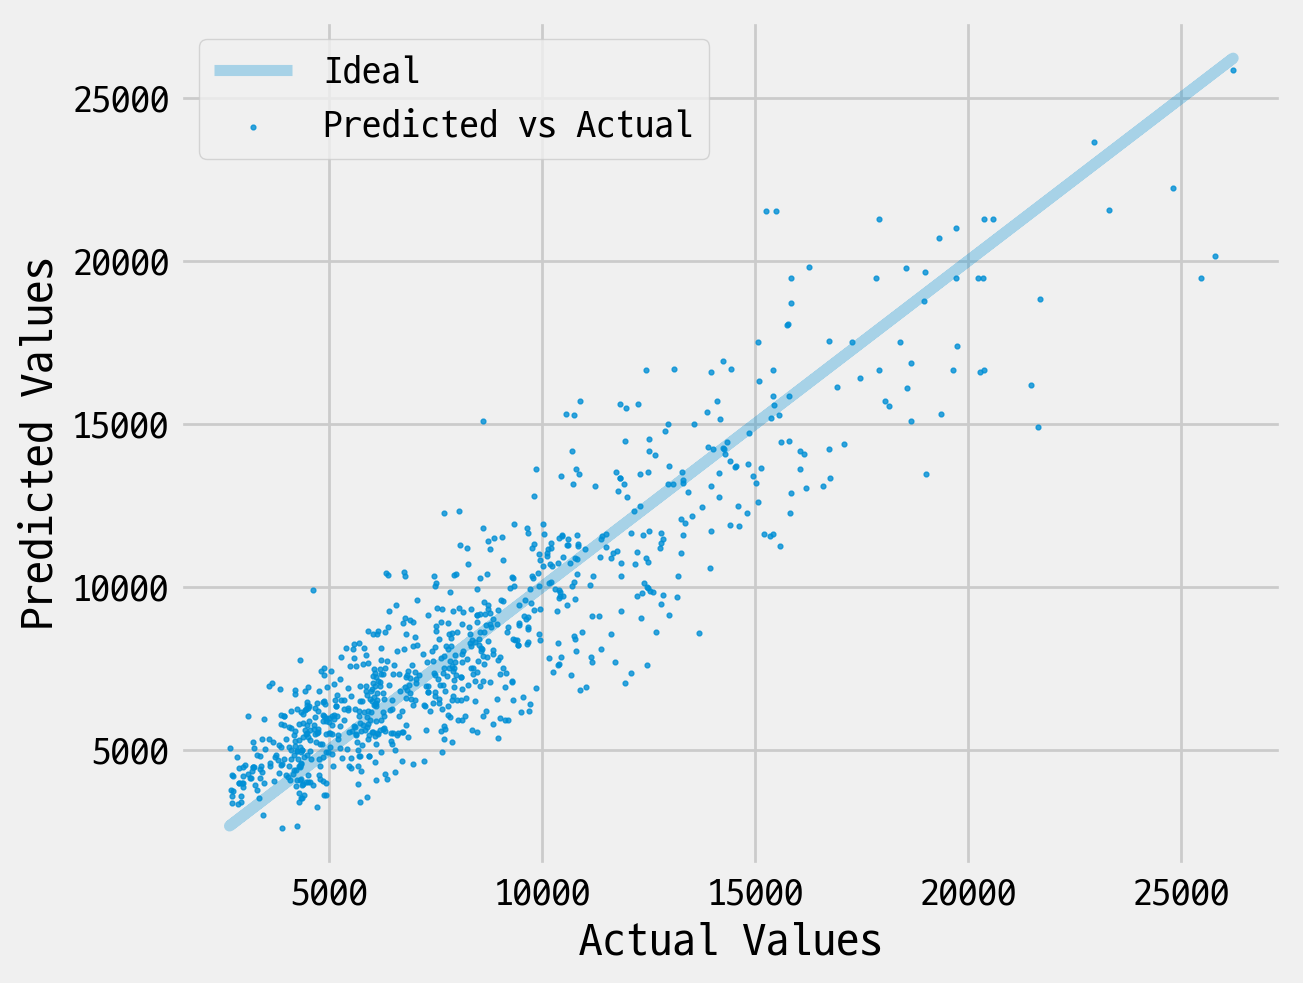

In [82]:
# 평가 지표 계산 및 출력
print("Train Mean Squared Error (MSE):", mse(y_train, y_pred_train))
print("Test Mean Squared Error (MSE):", mse(y_test, y_pred_test))
print()

print("Train Mean Absolute Percentage Error (MAPE):", mape(y_train, y_pred_train))
print("Test Mean Absolute Percentage Error (MAPE):", mape(y_test, y_pred_test))
print()
print(r2_score(y_test,y_pred_test))


# 예측 값과 실제 값을 비교하는 산점도 및 대각선 그래프
fig, ax = plt.subplots()
ax.plot(y_test, y_test, alpha=0.3, label='Ideal')  # 대각선 그래프 (y = y)
ax.scatter(y_test, y_pred_test, s=3, alpha=0.8, label='Predicted vs Actual')  # 실제 값 대 예측 값 산점도
ax.set_ylabel('Predicted Values')
ax.set_xlabel('Actual Values')
ax.legend()
pass

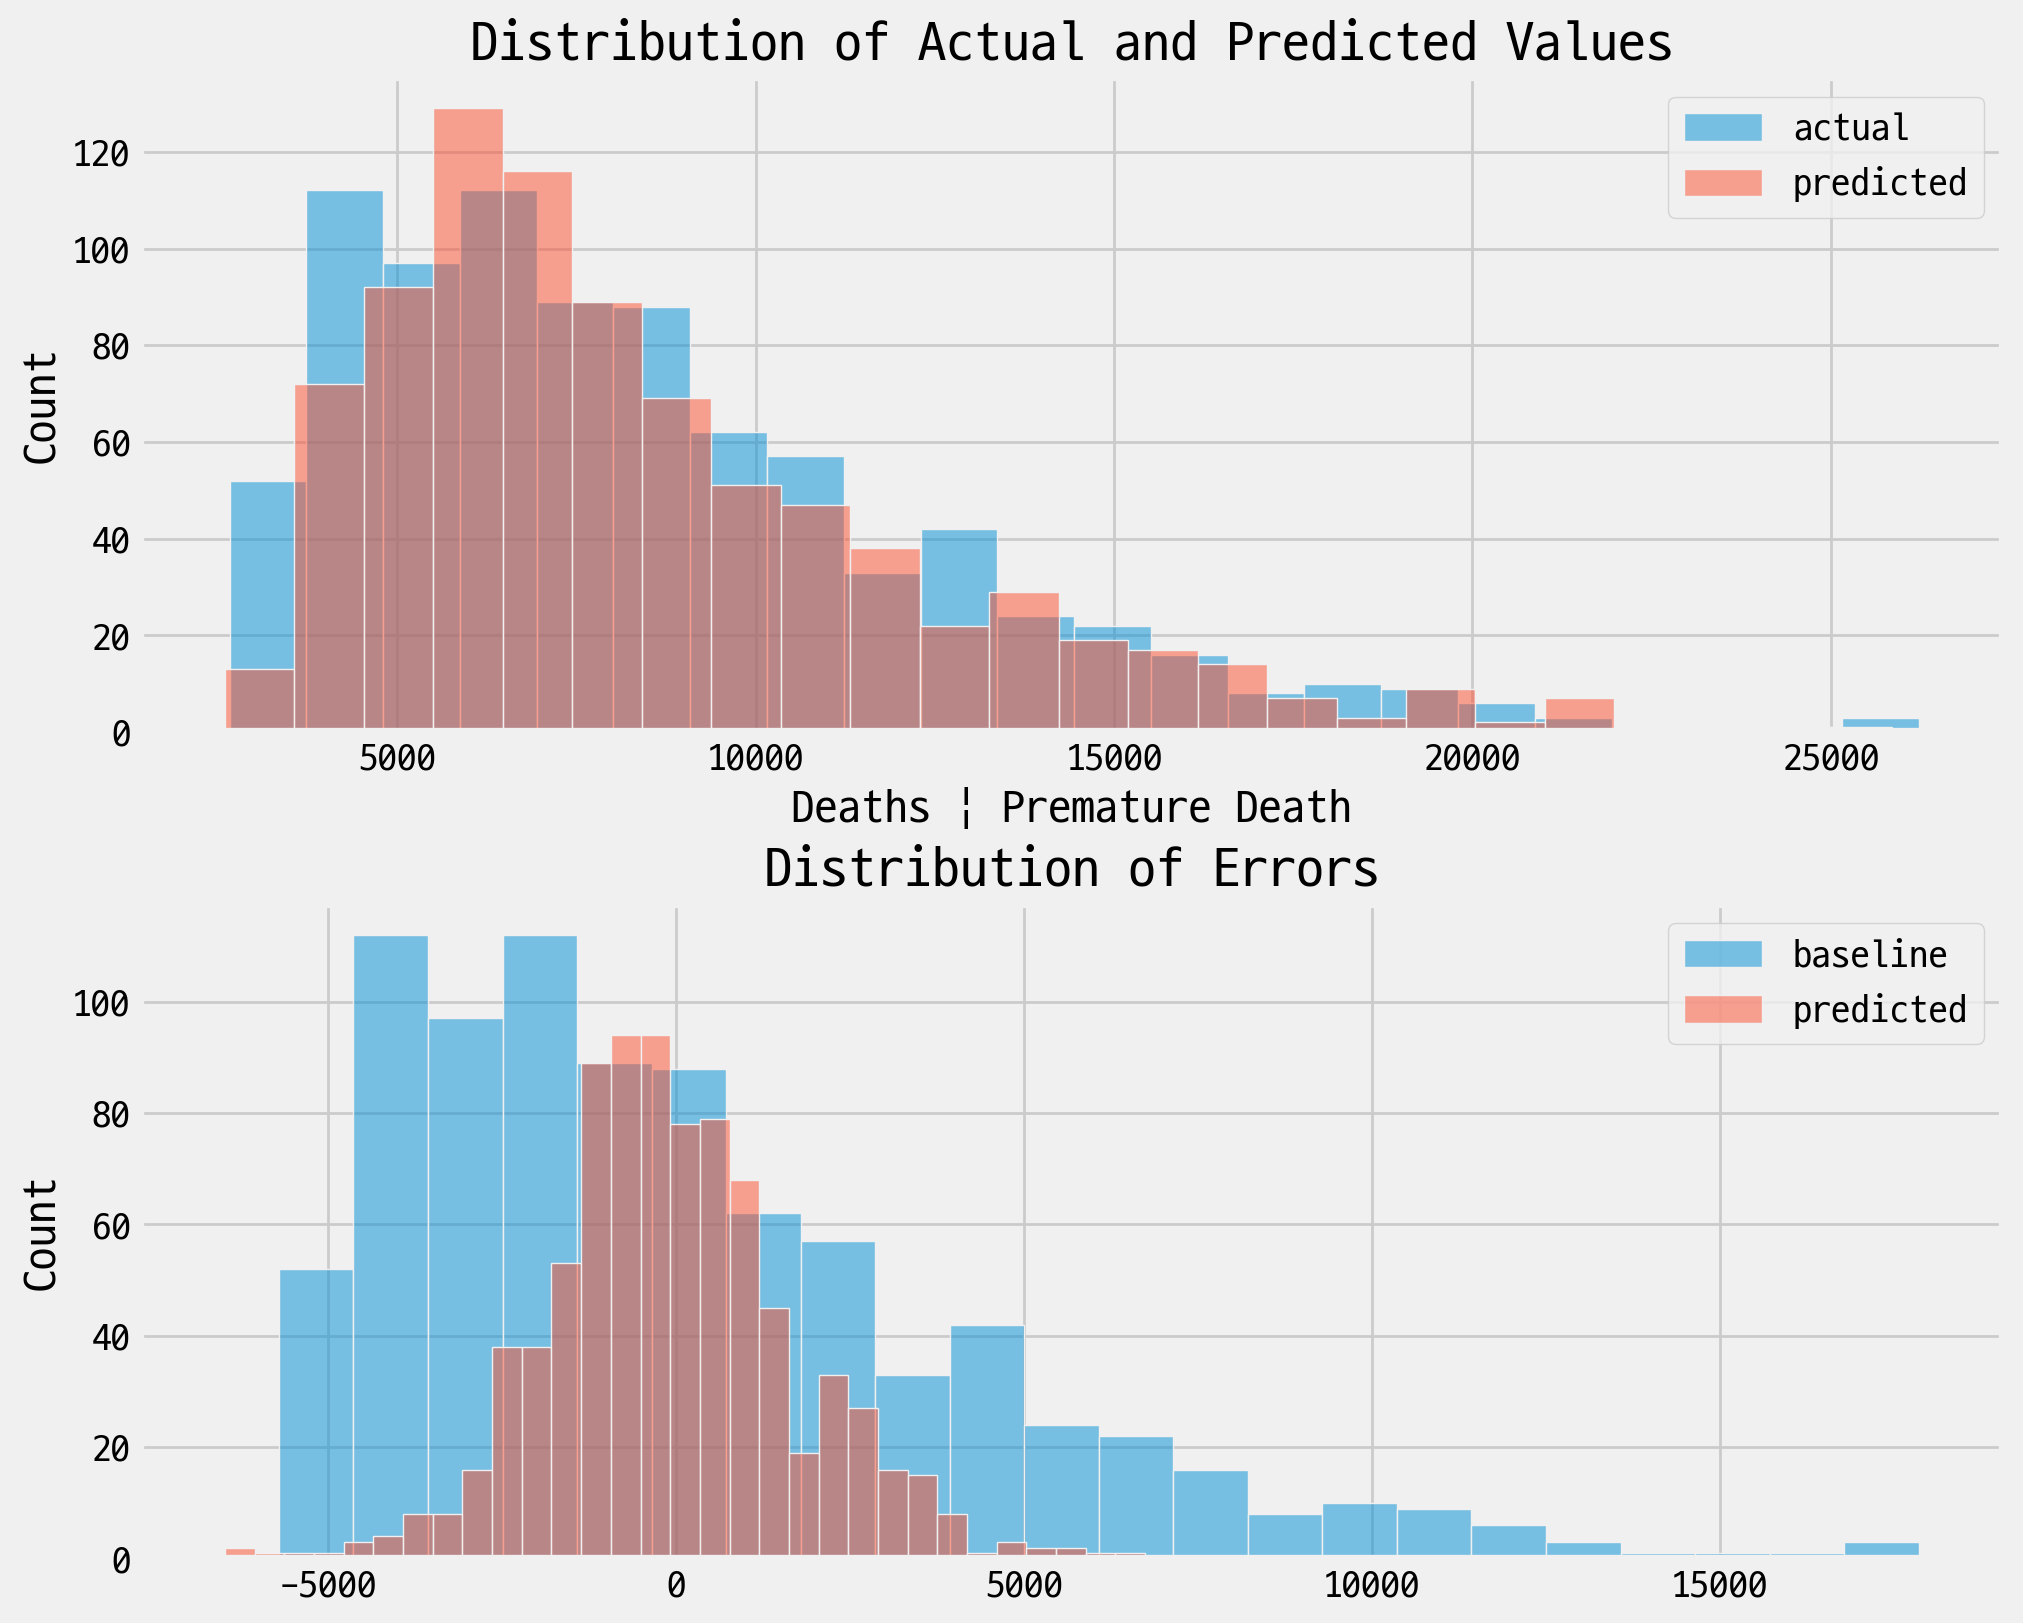

In [83]:
# 히스토그램 비교
fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 그래프 크기 조정 (옵션)

# 첫 번째 서브플롯: 실제 값과 예측 값의 히스토그램
sns.histplot(y_test, label='actual', ax=axes[0], alpha=0.5)
sns.histplot(y_pred_test, label='predicted', ax=axes[0], alpha=0.5)
axes[0].set_title('Distribution of Actual and Predicted Values')
axes[0].legend()

# 두 번째 서브플롯: 기준선과 예측 오차의 히스토그램
sns.histplot(y_test.values - np.mean(y_train), ax=axes[1], label='baseline', alpha=0.5)
sns.histplot((y_test.values - y_pred_test),ax=axes[1], label='predicted', alpha=0.5)
axes[1].set_title('Distribution of Errors')
axes[1].legend()

In [84]:
test_cols = [
    'Deaths | Premature Death',                                  
    'Deaths | Injury Deaths',                                    
    'Cancer | All Cancer Deaths',                                
    'Cardiovascular Disease | Cardiovascular Disease Deaths',    
    'Deaths | Deaths from All Causes',                           
    'Substance Use | Drug Overdose Deaths',                      
    'Cardiovascular Disease | Heart Disease Deaths',             
    'Diabetes and Obesity | Diabetes Deaths',                    
    'Cancer | Lung Cancer Deaths',                               
    'Life Expectancy at Birth | Life Expectancy',                
    'Mental Health | Suicide',                                   
    'Deaths | Motor Vehicle Deaths',                             
    'Deaths | Gun Deaths (Firearms)',                            
    'Respiratory Infection | Pneumonia or Influenza Deaths',     
    'Substance Use | Opioid Overdose Deaths',                    
    'Cancer | Colorectal Cancer Deaths',                         
    'Crime Incidents | Homicides',                               
]

In [91]:
test_cols =[
    'Substance Use | Opioid Overdose Deaths',                    
    'Births | Prenatal Care',                                    
    'Life Expectancy at Birth | Life Expectancy',                
    'Sexually Transmitted Disease | HIV/AIDS Prevalence',        
    'Respiratory Infection | Flu Vaccinations, Medicare',        
    'Health Insurance | Uninsured, Child',                       
    'Population | Single-Parent Families',                       
    'Active Transportation | Walking to Work',                   
    'Transportation | Drives Alone to Work',                     
    'Transportation | Public Transportation Use',                
    'Health Insurance | Uninsured, All Ages',                    
    'Deaths | Infant Deaths',                                    
    'Deaths | Maternal Deaths',                                  
    'Births | Preterm Births',                                   
]

In [92]:
len(test_cols)

14

In [93]:
def make_reg_score_dict(y_actual,y_pred,base_val):
    rmse_model, rmse_base = np.sqrt(mse(y_actual,y_pred)), np.sqrt(mse([base_val]*len(y_actual),y_actual))
    #msle_model, msle_base = msle(y_actual,y_pred), msle(y_actual,[base_val]*len(y_actual))
    msle_model, msle_base = 0,0 
    mape_model, mape_base = mape(y_actual,y_pred), mape([base_val]*len(y_actual),y_actual)
    r2_model, r2_base = r2_score(y_actual,y_pred), 0
    
    return {
        'rmse' : [rmse_model, rmse_base],
        'msle' : [msle_model, msle_base],
        'mape' : [mape_model, mape_base],
        'r2_score' : [r2_model,r2_base]
    }

def print_reg_score_dict(name,dict_score):
    print('{}\nr2 score : {:.5f}'.format(name,dict_score['r2_score'][0]))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score['mape']),
          'msle_model : {:.5f} / msle_base : {:.5f}'.format(*dict_score['msle']))

def make_reg_score_dict_cols(target_sample,dict_df,dict_train_test,dict_rslt,print_plot=False):
    dict_score = dict()
    for col in target_sample:
        train_y = dict_df[col]['train'][1]
        valid_y = dict_train_test[col][3]
        y_pred = dict_rslt[col]['valid']
        dict_score[col] = make_reg_score_dict(valid_y,y_pred,np.mean(train_y))
        if print_plot :
            print_reg_score_dict(col,dict_score[col])
            print('-'*150)
    return dict_score

## FUNCTIONS - DATA- PLOT REG RSLT
from itertools import repeat, chain

def scatter_reg_rslt(dict_train_test,dict_rslt,dict_score): #set_iput
    target_sample = list(dict_rslt.keys())
    data_plot ={
        col : (dict_train_test[col][3], dict_rslt[col]['valid'])
        for col in target_sample 
    }
    data_line = {
        col : (dict_train_test[col][3],dict_train_test[col][3])
        for col in target_sample 
    }
    fig,axes = plt.subplots(3,3,figsize=(12,12))
    fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_line,
    #fig,axes = pair_plot_feat_hue(fig=None,axes=None,data=data_line,
                                  pair_plot=sns.lineplot,lw=0.3)
    #fig.set_size_inches(12,8, forward=True)
    fig,axes = pair_plot_feat_hue(fig=fig,axes=axes,data=data_plot,
                                  pair_plot=sns.scatterplot,s=5,alpha=0.65)

    for n,key in enumerate(data_plot.keys()):
        ax = axes.flatten()[n]
        ax.set_ylabel('')
        ax.set_title(key,fontsize=12)
        ax.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>35}\n'.format(*dict_score[key]['rmse'],dict_score[key]['r2_score'][0],
            f'n = {len(dict_train_test[key][0])}'), fontsize=10, ha ='left')

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)
    
    return fig,axes

def plot_reg_score(dict_train_test,dict_rslt,dict_score,target_sample):
    data_plot ={
        col : (dict_train_test[col][3], dict_rslt[col]['valid'])
        for col in target_sample 
    }
    fig,axes = plt.subplots(len(data_plot),3,figsize=(15,20))
    for n, col in enumerate(data_plot.keys()):
        #quo, rem = divmod(n,3)
        ax1, ax2, ax3 = axes[n][0], axes[n][1], axes[n][2]
        test_y, y_pred = data_plot[col]
        train_y = dict_train_test[col][2]

        sns.histplot(test_y,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='knn_pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(test_y-np.mean(train_y),ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(test_y-y_pred,ax=ax2, label = 'knn_pred',alpha=0.5)
        ax2.legend(fontsize=9)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:4],y=list(df_score.values.reshape(-1))[:4],
                    hue = ['knn_pred','base']*2,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[4:],y=list(df_score.values.reshape(-1))[4:],
                    hue = ['knn_pred','base']*2,ax=ax3r,alpha=0.8,legend=False)
        ax3.set_yscale('log')
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')    
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')
        #ax3.axvline()

        ax1.set_title(str_cutter(col,50),fontsize=15,loc='left',ha='left')
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(dict_train_test[col][0])}'), fontsize=10,ha ='left')
        #ax2.xaxis.set_label_position('left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10) 
        ax2.set_ylabel('count',fontsize =10) 
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

In [96]:
import copy, time

info_cols = strata_one_hot_cols+strata_ordinal_cols
df_data = pvtb_encoded[info_cols+test_cols]


#main 함수 만드는 형식으로 코드 리팩토링 하기
# - dict 구조를 좀 더 효율적으로 정리해야 코드도 좀 더 정리될 것 같음
#   - dict_df 와 dict_train_test_split을 통합하거나 : train, val, target 으로 구분
#   - 저장 용량 효율화를 위해 data 전체가 아닌 idx, col 만을 저장하는 것도 방법 
# - 나중에 model 성능 테스트 떄 비교 용이를 위해서 knn_model 저장하는 오류도 해결하면 좋을 듯
#   - knn의 특성을 고려했을 떄 작업자/환경/돌아간 시간 도 저장하는 것이 나중에 발표에 도움될 듯
#전처리 과정에서 geo_strat별로 city_label 부여하고 metric_btwn_city 계산하는 것 넣기 : city label 안봐도 예측 가능하게끔
#저장한 dict 읽어올 때 좀 더 효율적이게 : cond_na, test_df에 대한 정보도 주는 쪽이 좋긴할텐데
#그치만 어차피 복잡한 상황은 아니라 통일되고 있다고 전제해도 될 듯
#param 추가 

target_cols = test_cols[::2]

dict_df = dict()
for col in target_cols:
    temp = df_data[info_cols+[col]]
    cond_na = temp.isna().any(axis=1)
    dict_df[col] = {
        'train' : [temp.loc[~cond_na,info_cols], temp.loc[~cond_na,col]],
        'target' : [temp.loc[cond_na,info_cols], cond_na],
    }

#train/validation
dict_train_test = {
    col: train_test_split(*dict_df[col]['train'],
                         test_size = 0.2,
                         random_state=801) #check how to using stratify option
    for col in target_cols}

metric = 'canberra'
model = KNeighborsRegressor(n_neighbors=7,weights='distance',metric=metric,algorithm='auto')

dict_knn, dict_rslt = dict(), dict()
for col in target_cols:
    knn_col = copy.deepcopy(model)
    train_X, train_y = dict_df[col]['train']
    _,valid_X,_,valid_y = dict_train_test[col]
    target_X, cond_na = dict_df[col]['target']

    start = time.time()
    knn_col.fit(train_X,train_y)
    y_pred_trgt = knn_col.predict(target_X)
    pred_start = time.time()
    y_pred_vlid = knn_col.predict(valid_X)
    end = time.time()

    print (col,f'/ train_n : {len(train_X)}/ target_n : {len(target_X)}/ time : {end-start:.5f} (sec)')
    dict_knn[col], dict_rslt[col] = knn_col, {'target':y_pred_trgt,
                                              'valid':y_pred_vlid,
                                              'pred_time' : end-pred_start}

dict_score = make_reg_score_dict_cols(target_cols,dict_df,dict_train_test,dict_rslt,print_plot=True)


Substance Use | Opioid Overdose Deaths / train_n : 4814/ target_n : 2466/ time : 0.48642 (sec)
Life Expectancy at Birth | Life Expectancy / train_n : 4992/ target_n : 2288/ time : 0.40672 (sec)
Respiratory Infection | Flu Vaccinations, Medicare / train_n : 1995/ target_n : 5285/ time : 0.26918 (sec)
Population | Single-Parent Families / train_n : 2205/ target_n : 5075/ time : 0.27023 (sec)
Transportation | Drives Alone to Work / train_n : 2205/ target_n : 5075/ time : 0.24417 (sec)
Health Insurance | Uninsured, All Ages / train_n : 2100/ target_n : 5180/ time : 0.25332 (sec)
Deaths | Maternal Deaths / train_n : 1001/ target_n : 6279/ time : 0.13202 (sec)
Substance Use | Opioid Overdose Deaths
r2 score : 0.88102
rmse_model : 9.77551 / rmse_base : 28.38244	 mape_model : 0.32459 / mape_base : 0.82655	 msle_model : 0.00000 / msle_base : 0.00000
---------------------------------------------------------------------------------------------------------------------------------------------------

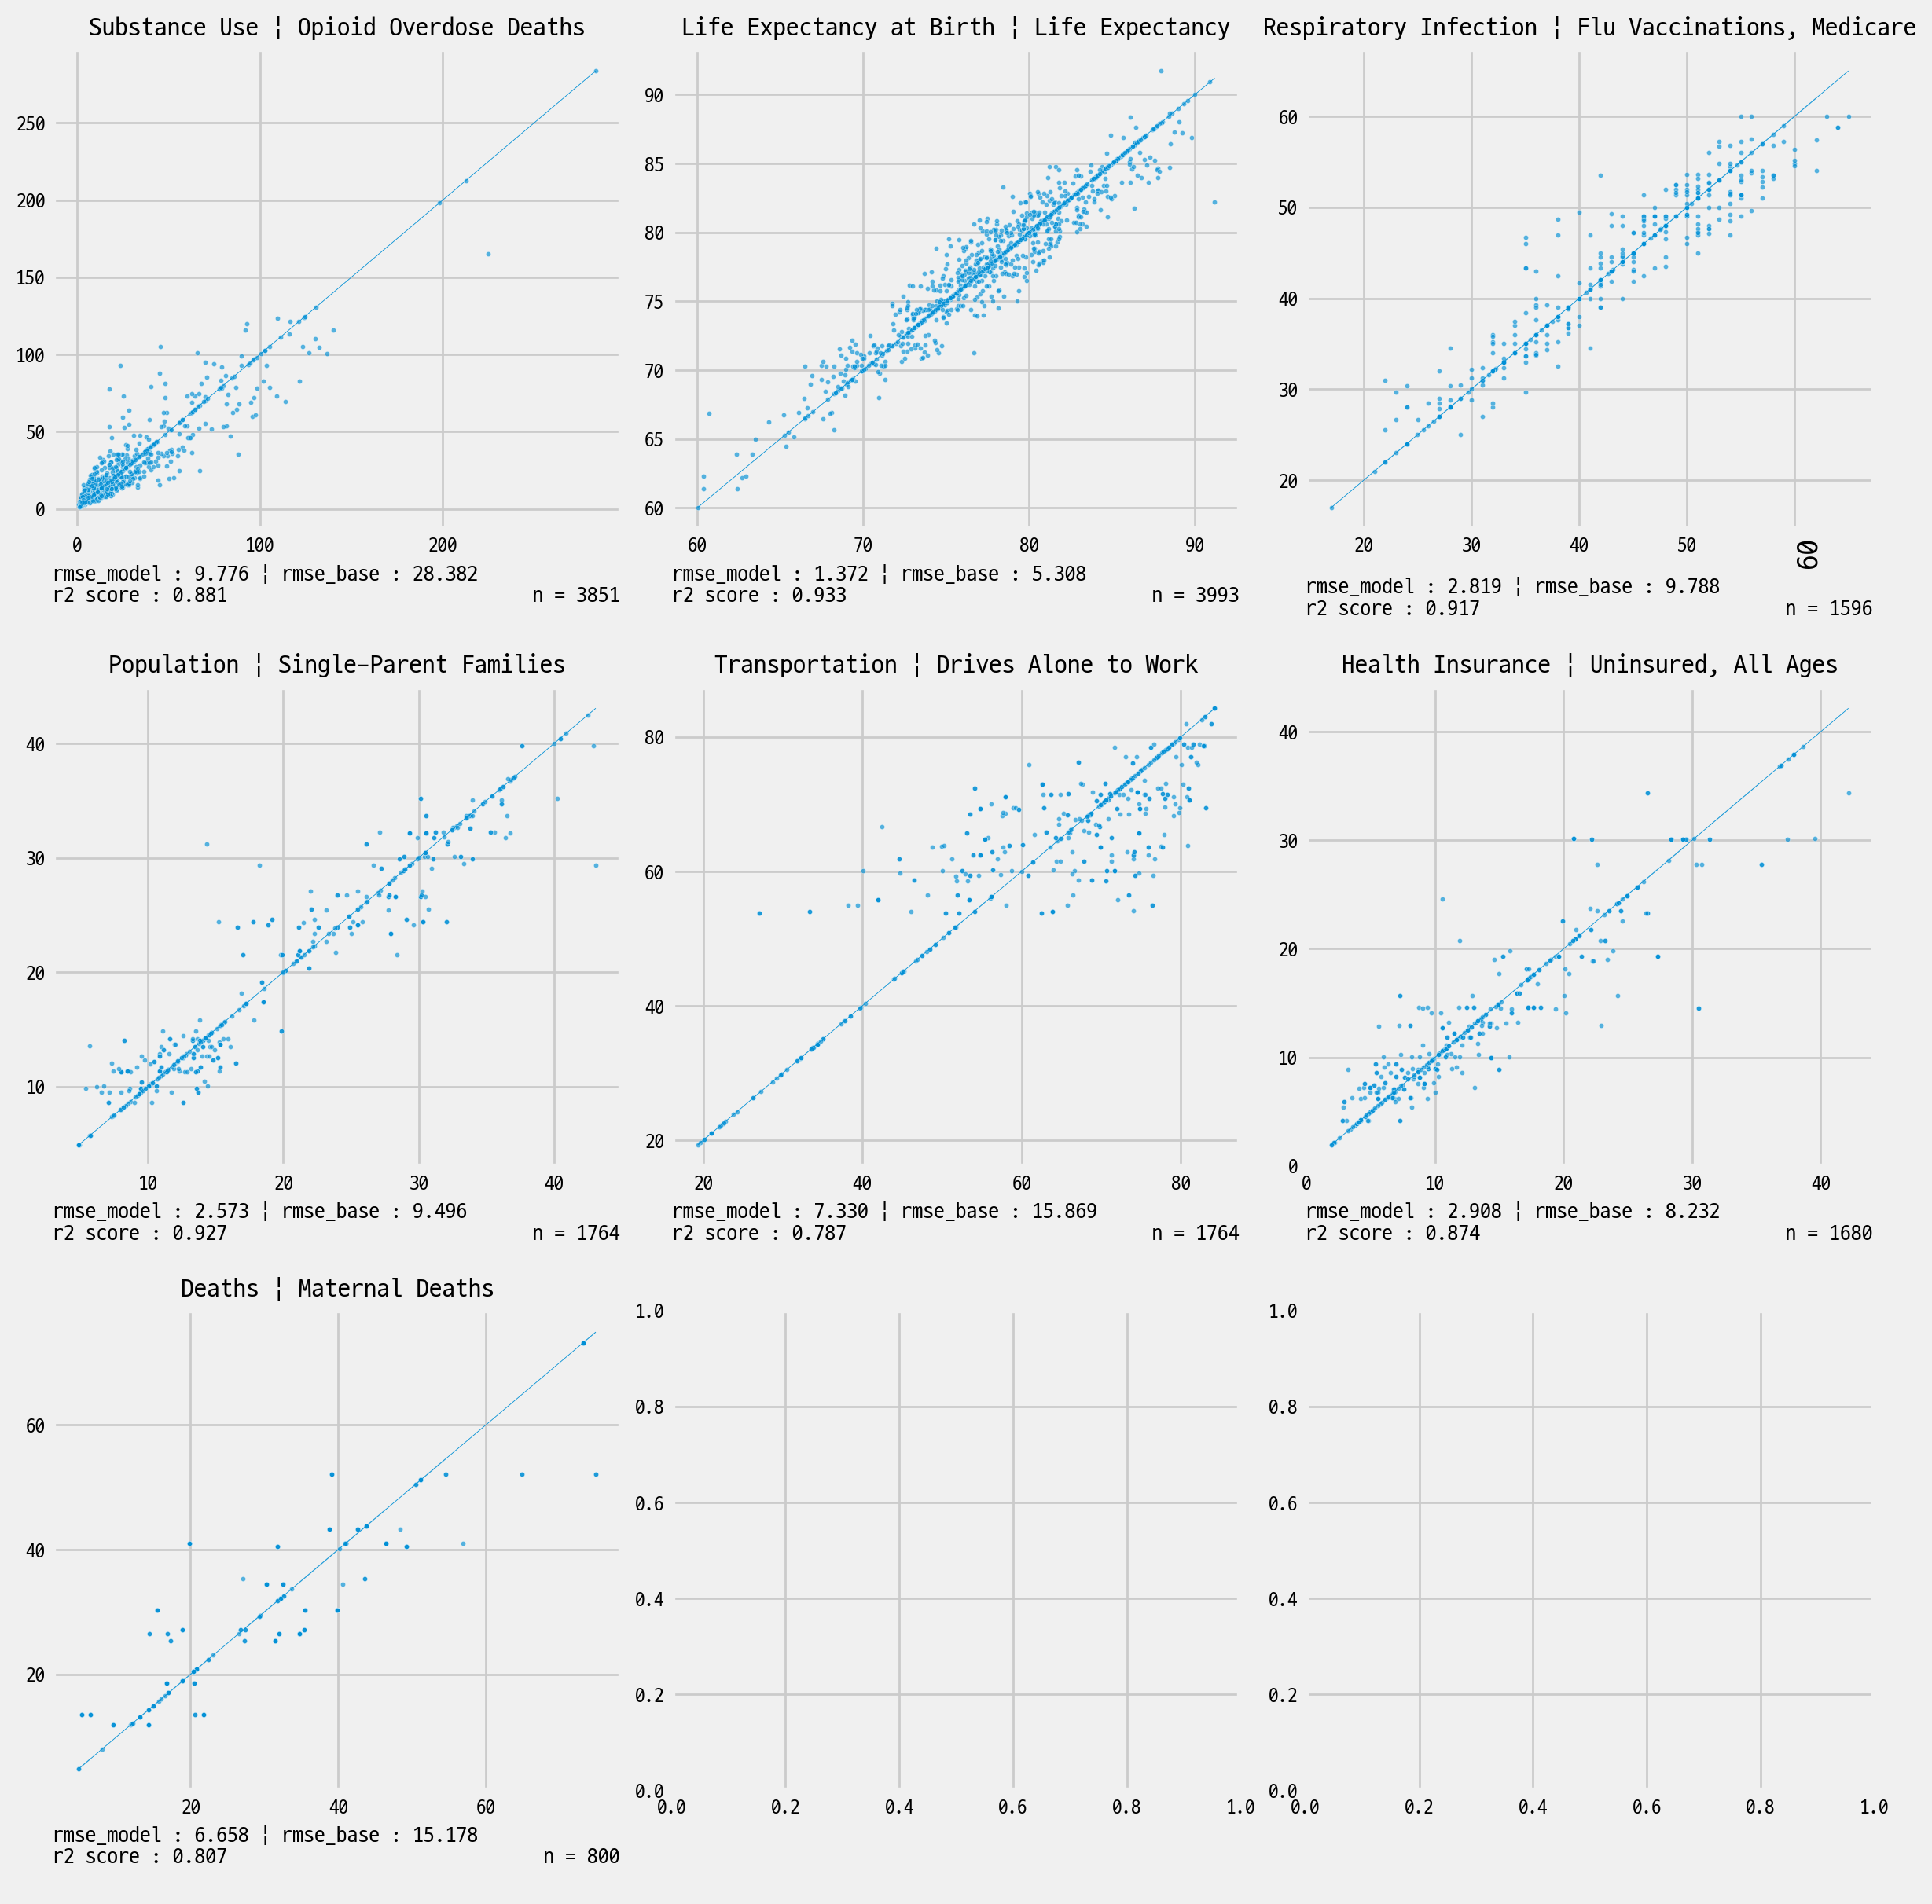

In [97]:
fig,axes = scatter_reg_rslt(dict_train_test,dict_rslt,dict_score)


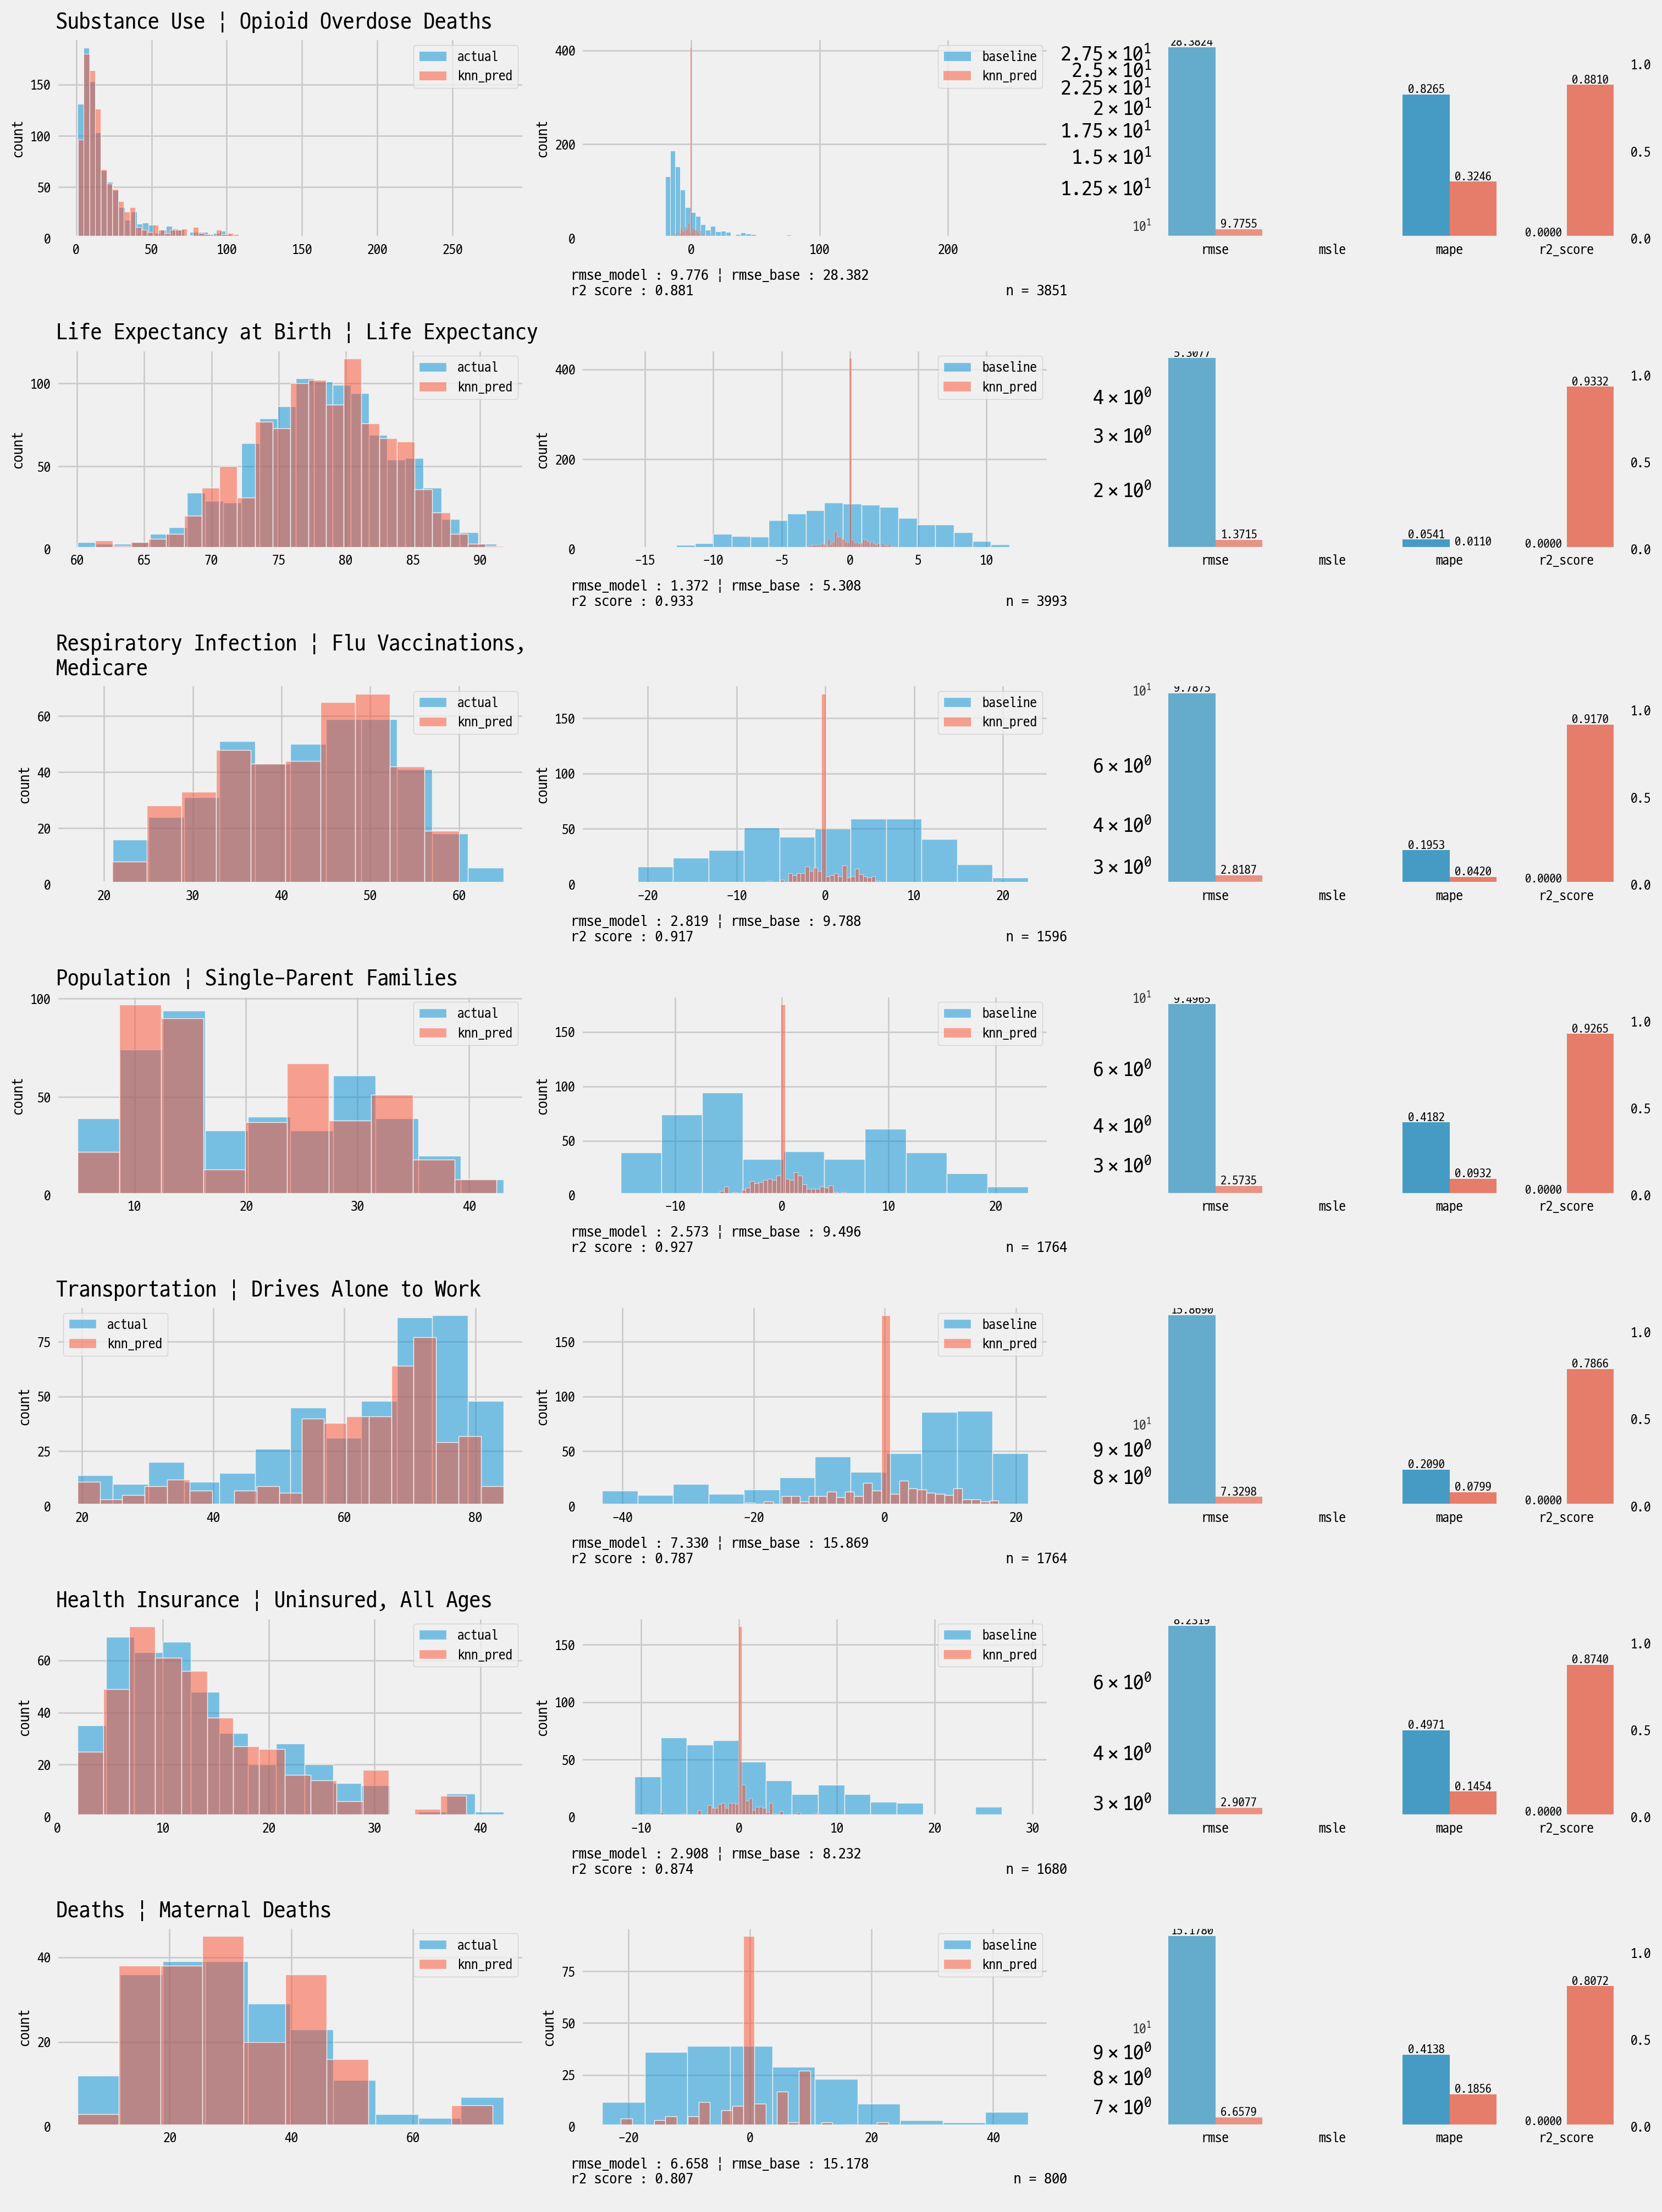

In [98]:

fig,axes = plot_reg_score(dict_train_test,dict_rslt,dict_score,target_cols)

Deaths | Premature Death
Train Mean Squared Error (MSE): 996096.8553000509
Test Mean Squared Error (MSE): 2142833.144858747
Train Mean Absolute Percentage Error (MAPE): 0.07481270211729436
Test Mean Absolute Percentage Error (MAPE): 0.1267220199777685
0.8746386326348826
Deaths | Deaths from All Causes
Train Mean Squared Error (MSE): 996096.8553000509
Test Mean Squared Error (MSE): 2142833.144858747
Train Mean Absolute Percentage Error (MAPE): 0.07481270211729436
Test Mean Absolute Percentage Error (MAPE): 0.1267220199777685
0.8746386326348826
Cancer | Lung Cancer Deaths
Train Mean Squared Error (MSE): 996096.8553000509
Test Mean Squared Error (MSE): 2142833.144858747
Train Mean Absolute Percentage Error (MAPE): 0.07481270211729436
Test Mean Absolute Percentage Error (MAPE): 0.1267220199777685
0.8746386326348826
Deaths | Gun Deaths (Firearms)
Train Mean Squared Error (MSE): 996096.8553000509
Test Mean Squared Error (MSE): 2142833.144858747
Train Mean Absolute Percentage Error (MAPE): 0.

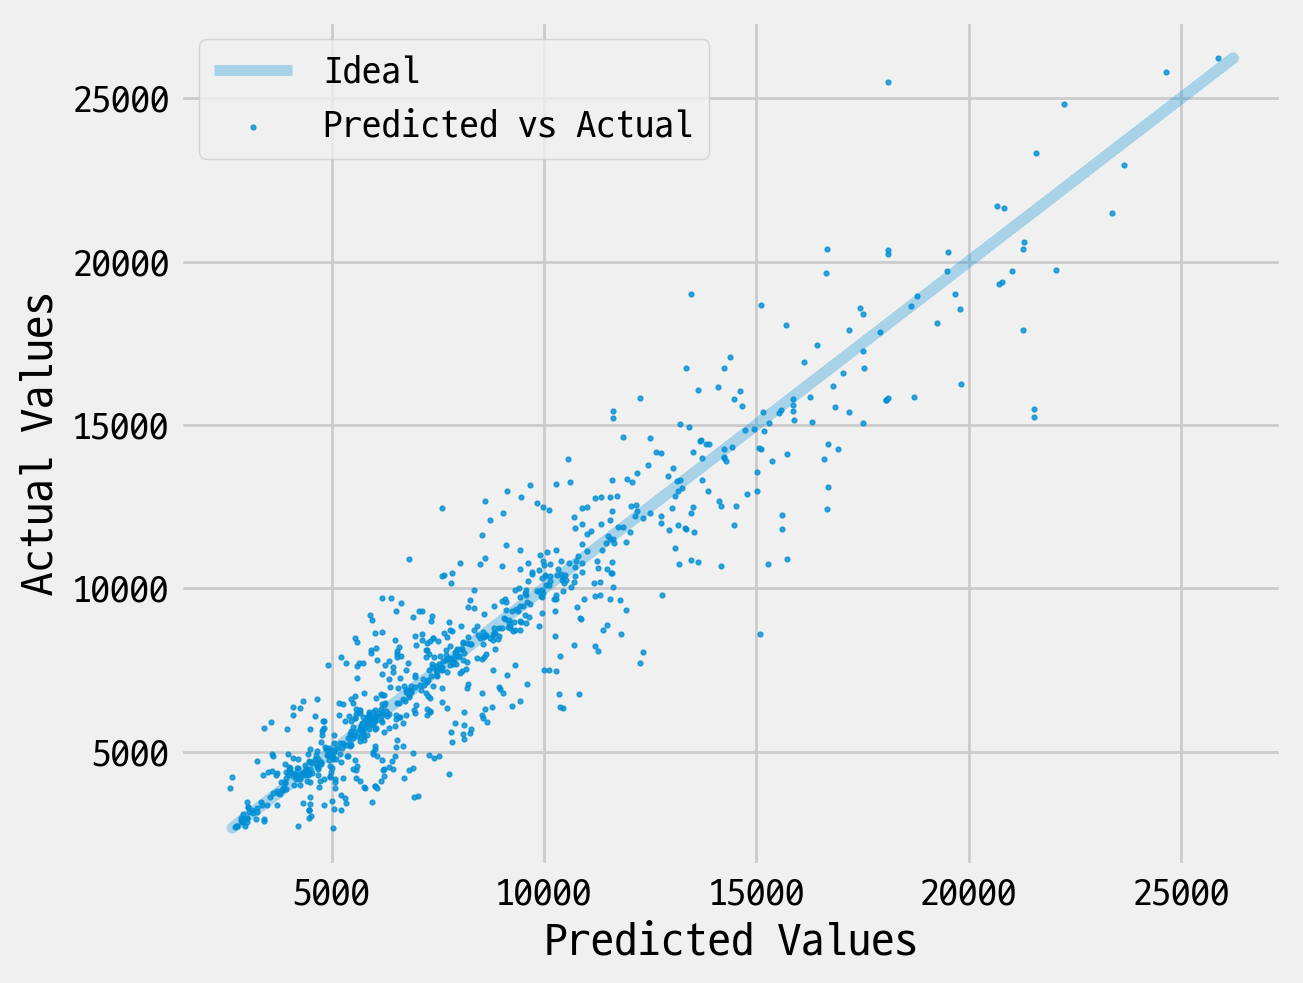

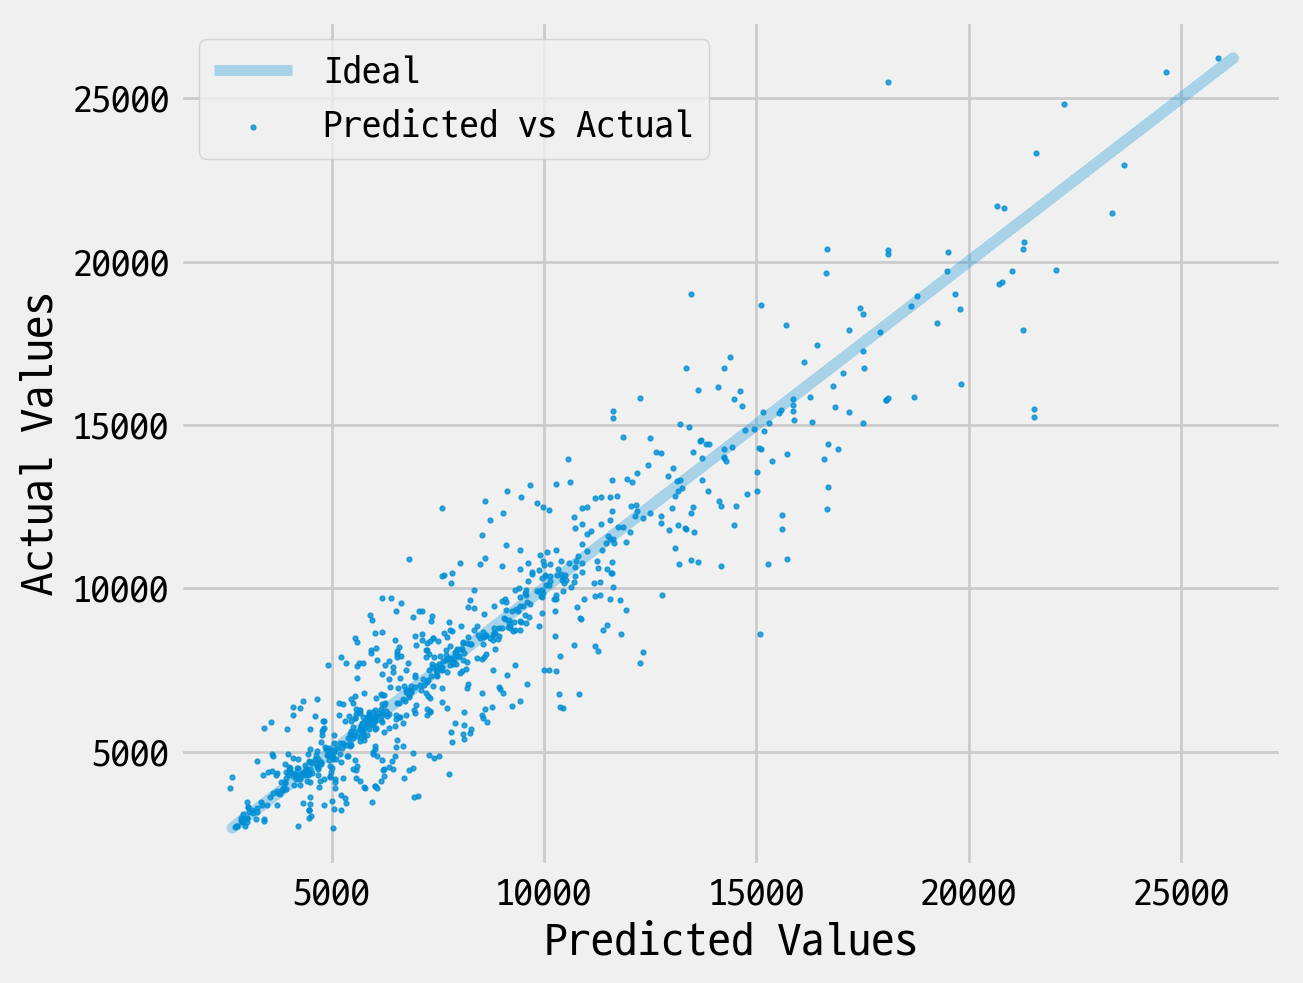

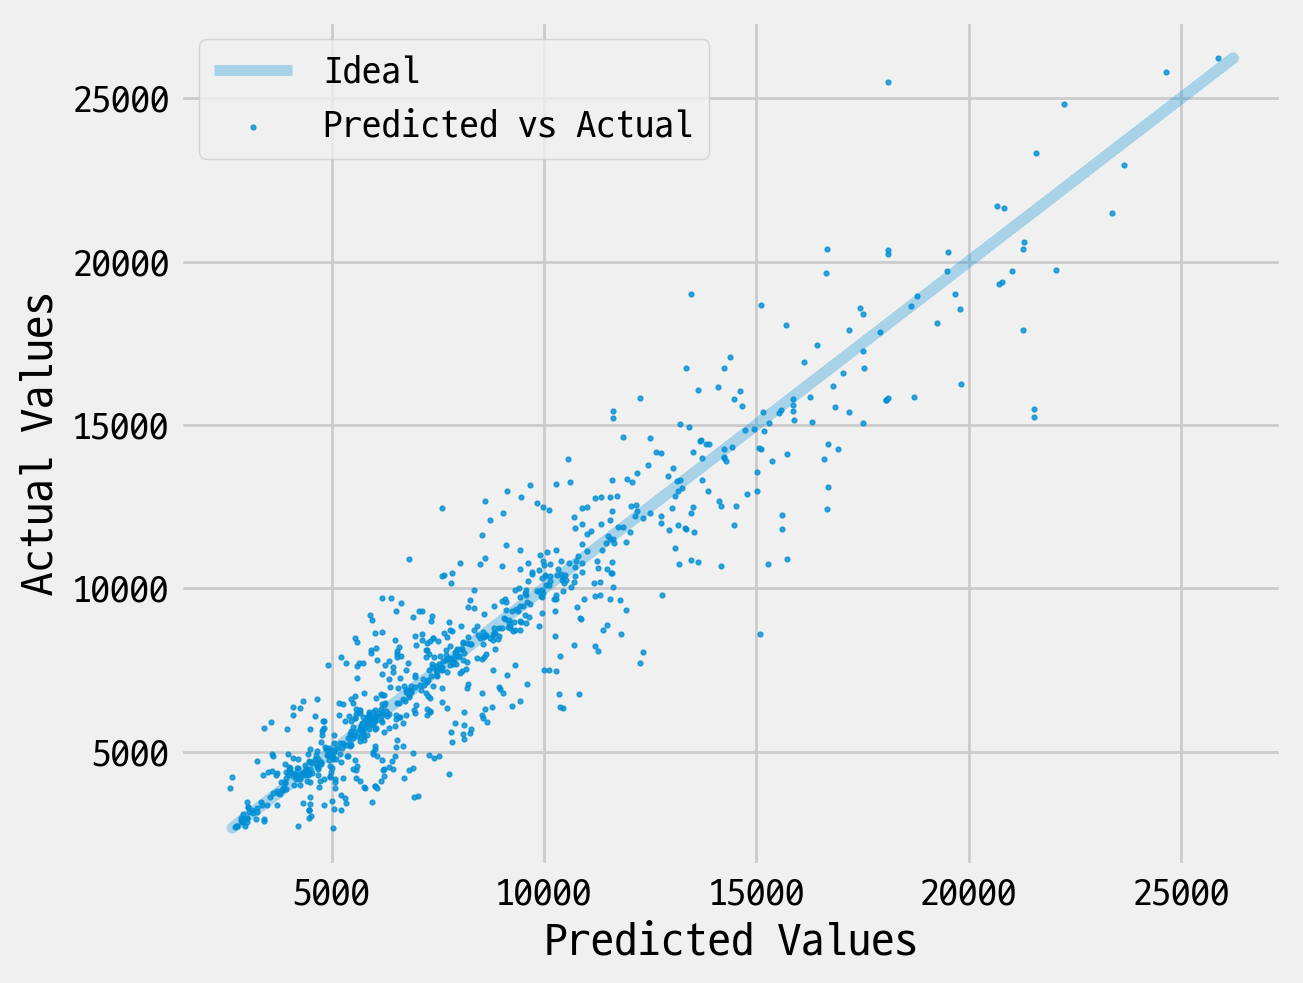

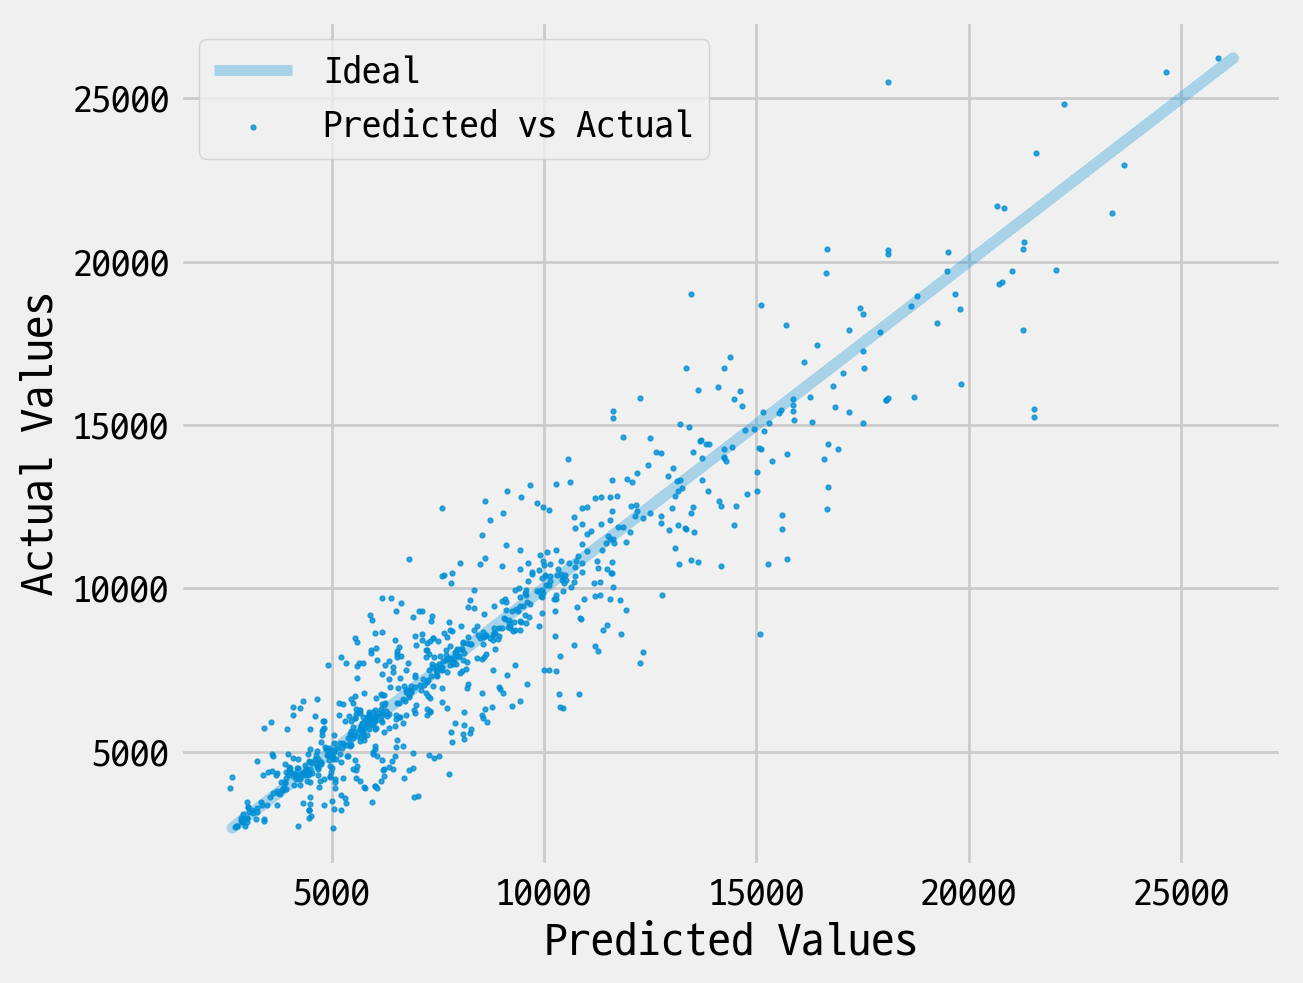

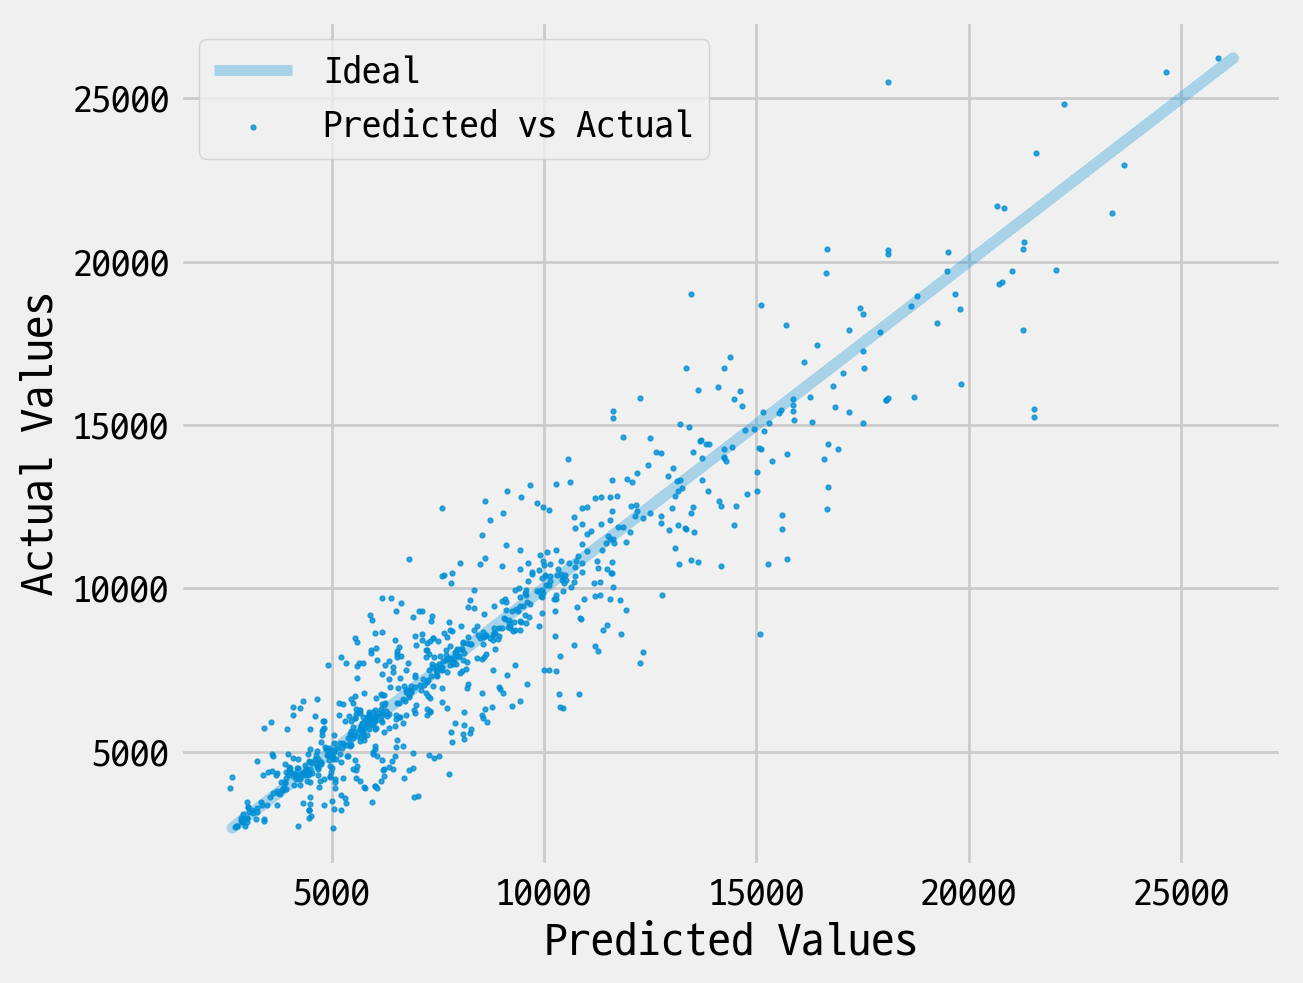

In [33]:
sample_cols = test_cols[::4]
df_data = pvtb_encoded[strata_one_hot_cols+strata_ordinal_cols+sample_cols]
df_nonan = df_data.dropna()

metric='cosine'
for test_col in sample_cols:
     
    X = df_nonan[strata_one_hot_cols+strata_ordinal_cols]
    y = df_nonan[target_col]
    
    # 학습 데이터와 테스트 데이터로 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=801)
    
    # 결정 트리 모델 생성 및 학습
    knn_model = KNeighborsRegressor(n_neighbors=7,weights='distance',algorithm='auto',metric=metric) 
    knn_model.fit(X_train, y_train)
    
    # 예측 수행
    y_pred_train = knn_model.predict(X_train)
    y_pred_test = knn_model.predict(X_test)
    
    # 평가 지표 계산 및 출력
    print(test_col)
    print("Train Mean Squared Error (MSE):", mse(y_train, y_pred_train))
    print("Test Mean Squared Error (MSE):", mse(y_test, y_pred_test))
    
    print("Train Mean Absolute Percentage Error (MAPE):", mape(y_train, y_pred_train))
    print("Test Mean Absolute Percentage Error (MAPE):", mape(y_test, y_pred_test))
    print(r2_score(y_pred_test,y_test))
    
    
    # 예측 값과 실제 값을 비교하는 산점도 및 대각선 그래프
    fig, ax = plt.subplots()
    ax.plot(y_test, y_test, alpha=0.3, label='Ideal')  # 대각선 그래프 (y = y)
    ax.scatter(y_pred_test, y_test, s=3, alpha=0.8, label='Predicted vs Actual')  # 실제 값 대 예측 값 산점도
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.legend()